In [1]:
import cv2
import numpy as np
import urllib

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.ensemble import RandomForestClassifier

In [2]:
SZ=20
bin_n = 16 # Number of bins
affine_flags = cv2.WARP_INVERSE_MAP|cv2.INTER_LINEAR

In [3]:
def deskew(img):
    m = cv2.moments(img)
    if abs(m['mu02']) < 1e-2:
        return img.copy()
    skew = m['mu11']/m['mu02']
    M = np.float32([[1, skew, -0.5*SZ*skew], [0, 1, 0]])
    img = cv2.warpAffine(img,M,(SZ, SZ),flags=affine_flags)
    return img

def hog(img):
    gx = cv2.Sobel(img, cv2.CV_32F, 1, 0)
    gy = cv2.Sobel(img, cv2.CV_32F, 0, 1)
    mag, ang = cv2.cartToPolar(gx, gy)
    bins = np.int32(bin_n*ang/(2*np.pi))    # quantizing binvalues in (0...16)
    bin_cells = bins[:10,:10], bins[10:,:10], bins[:10,10:], bins[10:,10:]
    mag_cells = mag[:10,:10], mag[10:,:10], mag[:10,10:], mag[10:,10:]
    hists = [np.bincount(b.ravel(), m.ravel(), bin_n) for b, m in zip(bin_cells, mag_cells)]
    hist = np.hstack(hists)     # hist is a 64 bit vector
    return hist

In [4]:
def read_image_from_url(url):
    req = urllib.request.urlopen(url)
    arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
    img = cv2.imdecode(arr, -1) # 'Load it as it is'
    return img

In [5]:
url = "https://www.researchgate.net/profile/Nicol_Schraudolph/publication/237452158/figure/fig1/AS:298786795606021@1448247731187/A-sample-of-the-handwritten-digit-database-due-to-Guyon-et-al-1989-The-digits-have_Q320.jpg"
img = read_image_from_url(url)

(320, 320)


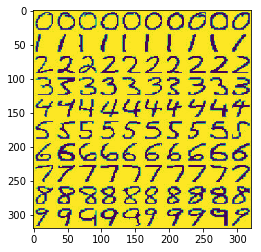

In [6]:
print(img.shape)
plt.imshow(img)

In [7]:
cells = [np.hsplit(row,10) for row in np.vsplit(img,10)]

# First half is trainData, remaining is testData
train_cells = [ i[:5] for i in cells ]
test_cells = [ i[5:] for i in cells]

######     Now training      ########################

hogdata = [list(map(hog,row)) for row in train_cells]
trainData = np.float32(hogdata).reshape(-1,64)
responses = np.int64(np.repeat(np.arange(10),5))

In [8]:
hogdata = [list(map(hog,row)) for row in test_cells]
testData = np.float32(hogdata).reshape(-1,bin_n*4)
y = np.int64(np.repeat(np.arange(10),5))

In [9]:
testData.shape, y.shape

((50, 64), (50,))

### Classification Model

In [10]:
rf_clf = RandomForestClassifier(n_estimators=200)

In [11]:
rf_clf.fit(trainData, responses)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [12]:
rf_clf.score(trainData, responses)

1.0

In [13]:
y_pred = rf_clf.predict(testData)

In [14]:
rf_clf.score(testData, y)

0.84

### Misclassified Samples

In [15]:
misclassified_indexes = np.where((y_pred != y).reshape(10,5))
n_misclassified = len(np.array(test_cells)[misclassified_indexes])
n_misclassified

8

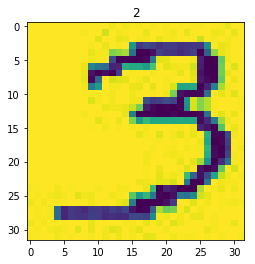

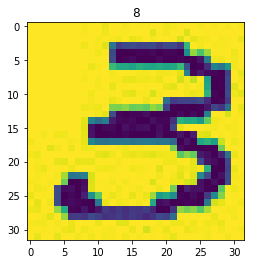

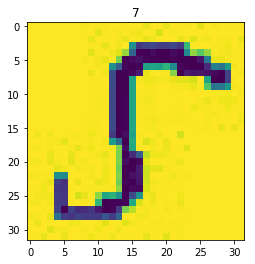

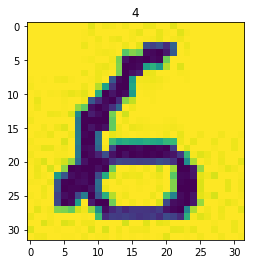

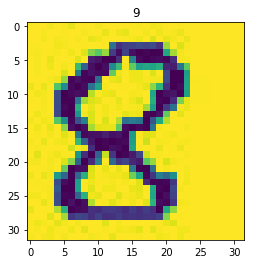

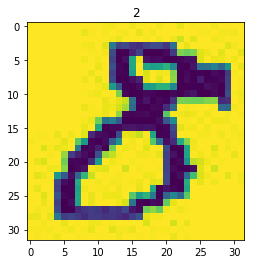

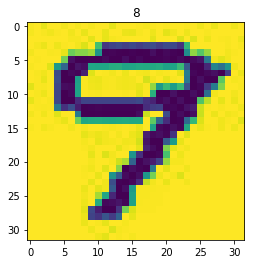

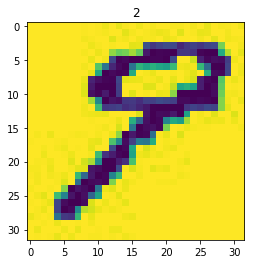

In [16]:
for i in range(n_misclassified):
    plt.figure()
    plt.imshow(np.array(test_cells)[misclassified_indexes][i])
    plt.title(np.array(y_pred).reshape(10,5)[misclassified_indexes][i])

### HOG features plot

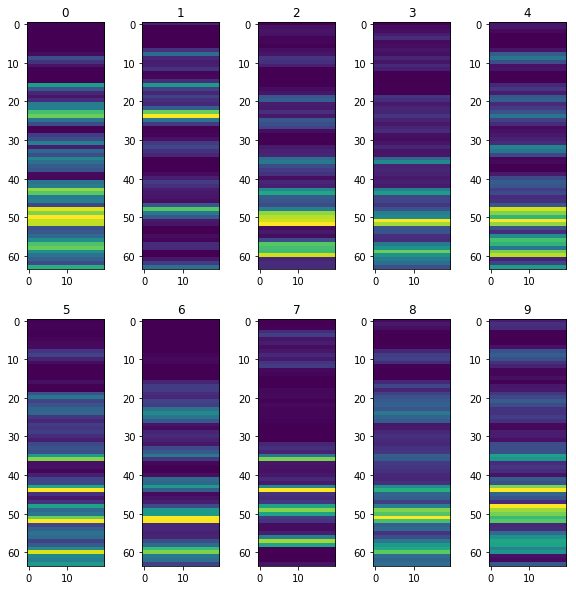

In [17]:
fig, axs = plt.subplots(2,5, figsize=(10,10))

for i in range(10):
    ax = axs[int(i/5)][int(i%5)]
    ax.imshow(np.repeat(np.mean(hogdata[i], axis=0)[:,np.newaxis], 20, axis=1))
    ax.set_title(str(responses[i*5]))